In [ ]:
import pandas as pd
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_all=np.load("drive/MyDrive/speaker/train_gray.npy")

X_all = X_all.astype('float16')
X_all = X_all/255

In [ ]:
Y_all=pd.read_csv("drive/MyDrive/speaker/filelist.csv",index_col=0)


In [ ]:

test=np.loadtxt("drive/MyDrive/speaker/testing_list.txt",dtype="str")

test=np.char.replace(test,".wav","")

test=np.char.split(test,"/")

test_name=np.array([x[1] for x in test])
test_type=np.array([x[0] for x in test])


In [ ]:
valid=np.loadtxt("drive/MyDrive/speaker/validation_list.txt",dtype="str")

valid=np.char.replace(valid,".wav","")

valid=np.char.split(valid,"/")

valid_name=np.array([x[1] for x in valid])
valid_type=np.array([x[0] for x in valid])

In [ ]:
Y_all.Name=Y_all.Name.str.replace(".png","")

Y_all["Index"]=Y_all.index


In [ ]:

valid=pd.DataFrame({"Name":valid_name,"Type":valid_type})

test=pd.DataFrame({"Name":test_name,"Type":test_type})

valid=pd.merge(Y_all,valid,on=["Name","Type"],how="right")

test=pd.merge(Y_all,test,on=["Name","Type"],how="right")

test.Index.isna().any(), valid.Index.isna().any()

(False, False)

In [ ]:
x_val=X_all[valid.Index]

y_val=Y_all.iloc[valid.Index].Type.to_numpy()

x_test=X_all[test.Index]

y_test=Y_all.iloc[test.Index].Type.to_numpy()

Y_all=Y_all[~Y_all.Index.isin(valid.Index)]
Y_all=Y_all[~Y_all.Index.isin(test.Index)]

x_train=X_all[Y_all.Index]

y_train=Y_all.Type.to_numpy()

In [ ]:
classes=np.unique(y_train)


In [ ]:
del X_all

del Y_all

In [ ]:
commands=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
classes[np.isin(classes,commands,invert=True)]="unknown"
y_test[np.isin(y_test,commands,invert=True)]="unknown"
y_val[np.isin(y_val,commands,invert=True)]="unknown"
y_train[np.isin(y_train,commands,invert=True)]="unknown"

In [ ]:
noise=np.load("drive/MyDrive/speaker/noise_grey.npy")

noise = noise.astype('float16')
noise = noise/255
noise.shape

(406, 99, 161, 1)

In [ ]:
noise[0:300].shape,noise[351:406].shape,noise[301:350].shape

((300, 99, 161, 1), (55, 99, 161, 1), (49, 99, 161, 1))

In [ ]:
np.concatenate((x_train, noise[0:300])).shape, x_train.shape

((51388, 99, 161, 1), (51088, 99, 161, 1))

In [ ]:
x_train_noise = np.concatenate((x_train, noise[0:300]))
del x_train

In [ ]:
x_val_noise = np.concatenate((x_val, noise[351:406]))
del x_val

In [ ]:
x_test_noise = np.concatenate((x_test, noise[301:350]))
del x_test

In [ ]:
y_train = np.concatenate((y_train,np.repeat('silence', 300, axis=0)))
y_test = np.concatenate((y_test,np.repeat('silence', 49, axis=0)))
y_val = np.concatenate((y_val,np.repeat('silence', 55, axis=0)))

In [ ]:
x_train_noise = np.concatenate((x_train_noise, x_val_noise))

In [ ]:
del x_val_noise

In [ ]:
y_train = np.concatenate((y_train, y_val))
del y_val

In [ ]:
from sklearn import preprocessing
pre = preprocessing.LabelEncoder()
pre.fit(y_train)
y_train = pre.transform(y_train)
y_test= pre.transform(y_test)
y_train = keras.utils.to_categorical(y_train, num_classes=12)
y_test = keras.utils.to_categorical(y_test, num_classes=12)

In [ ]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 30
data_augmentation = True
num_classes = 12
subtract_pixel_mean = True
n=3
depth = n * 6 + 2
input_shape = x_train_noise.shape[1:]
input_shape

(99, 161, 1)

In [ ]:
if subtract_pixel_mean:
    train_mean = np.mean(x_train_noise, axis=0)
    x_train_noise -= train_mean
    x_test_noise -= train_mean

In [ ]:
#np.save('drive/MyDrive/train_valid_mean.npy',train_mean)

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=12):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = resnet_v1(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 161, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 161, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 161, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 161, 16)  0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
len(np.unique(y_train)), len(np.unique(y_test))

(12, 12)

In [ ]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d3'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Not using data augmentation.
Epoch 1/30
Learning rate:  0.001
1821/1821 [==============================] - 501s 268ms/step - loss: 1.1607 - accuracy: 0.7271 - val_loss: 0.7228 - val_accuracy: 0.8530
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3/assets
Epoch 2/30
Learning rate:  0.001
1821/1821 [==============================] - 486s 267ms/step - loss: 0.3583 - accuracy: 0.9325 - val_loss: 0.8681 - val_accuracy: 0.8222
Epoch 3/30
Learning rate:  0.001
1821/1821 [==============================] - 486s 267ms/step - loss: 0.2786 - accuracy: 0.9515 - val_loss: 0.5327 - val_accuracy: 0.8902
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3/assets
Epoch 4/30
Learning rate:  0.001
1821/1821 [==============================] - 486s 267ms/step - loss: 0.2464 - accuracy: 0.9597 - val_loss: 0.4406 - val_accuracy: 0.8980
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3/assets
Epoch 5/30
Lear

KeyboardInterrupt: ignored

In [ ]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


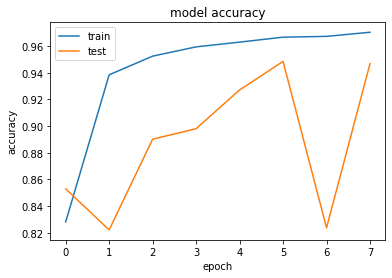

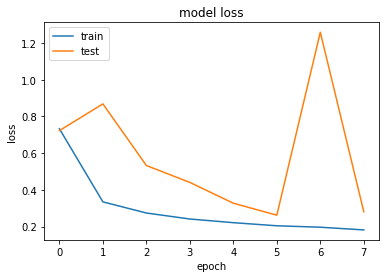

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#### model z depth = 2 ####

n=2
depth = n * 6 + 2

In [ ]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d2'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Not using data augmentation.
Epoch 1/30
Learning rate:  0.001
1821/1821 [==============================] - 493s 268ms/step - loss: 1.3108 - accuracy: 0.7034 - val_loss: 0.6211 - val_accuracy: 0.8617
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d2/assets
Epoch 2/30
Learning rate:  0.001
1821/1821 [==============================] - 487s 267ms/step - loss: 0.3757 - accuracy: 0.9257 - val_loss: 0.3445 - val_accuracy: 0.9391
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d2/assets
Epoch 3/30
Learning rate:  0.001
1821/1821 [==============================] - 488s 268ms/step - loss: 0.2906 - accuracy: 0.9477 - val_loss: 0.3329 - val_accuracy: 0.9371
Epoch 4/30
Learning rate:  0.001
1821/1821 [==============================] - 487s 267ms/step - loss: 0.2520 - accuracy: 0.9567 - val_loss: 0.3789 - val_accuracy: 0.9227
Epoch 5/30
Learning rate:  0.001
1821/1821 [==============================] - 487s 268ms/step - loss: 0.223

KeyboardInterrupt: ignored

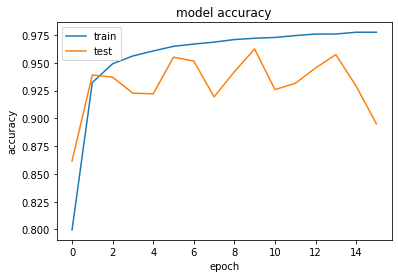

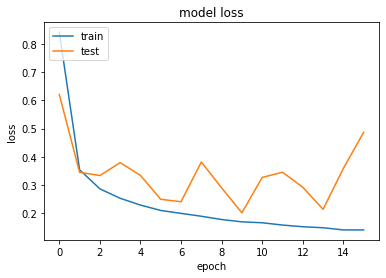

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#### model z depth = 1 ####

n=1
depth = n * 6 + 2

In [ ]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d1'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Not using data augmentation.
Epoch 1/30
Learning rate:  0.001
1821/1821 [==============================] - 535s 276ms/step - loss: 1.1772 - accuracy: 0.7211 - val_loss: 0.9514 - val_accuracy: 0.7760
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d1/assets
Epoch 2/30
Learning rate:  0.001
1821/1821 [==============================] - 502s 275ms/step - loss: 0.3544 - accuracy: 0.9320 - val_loss: 0.5171 - val_accuracy: 0.8854
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d1/assets
Epoch 3/30
Learning rate:  0.001
1821/1821 [==============================] - 501s 275ms/step - loss: 0.2826 - accuracy: 0.9513 - val_loss: 0.4576 - val_accuracy: 0.8850
Epoch 4/30
Learning rate:  0.001
1821/1821 [==============================] - 501s 275ms/step - loss: 0.2895 - accuracy: 0.9467 - val_loss: 0.2743 - val_accuracy: 0.9463
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d1/assets
Epoch 5/30
Lear

KeyboardInterrupt: ignored

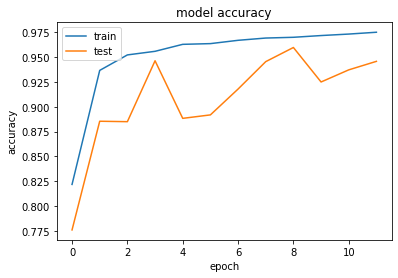

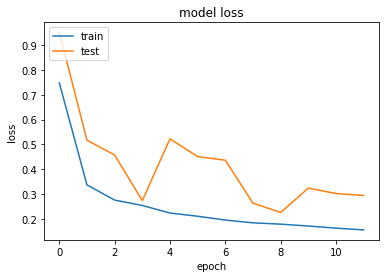

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#### z augmentacja ####

In [ ]:
data_augmentation = True


In [ ]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d3_aug'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
Learning rate:  0.001
456/456 [==============================] - 450s 918ms/step - loss: 1.7446 - accuracy: 0.6107 - val_loss: 1.5697 - val_accuracy: 0.5847
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug/assets
Epoch 2/30
Learning rate:  0.001
456/456 [==============================] - 417s 913ms/step - loss: 1.0883 - accuracy: 0.7033 - val_loss: 1.0387 - val_accuracy: 0.7198
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug/assets
Epoch 3/30
Learning rate:  0.001
456/456 [==============================] - 417s 913ms/step - loss: 0.6915 - accuracy: 0.8212 - val_loss: 0.8007 - val_accuracy: 0.7801
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug/assets
Epoch 4/30
Learning rate:  0.001
456/456 [==============================] - 417s 913ms/step - loss: 0.5255 - accuracy: 0.8741 - val_loss: 0.4704 - val_accuracy: 0.8865
INFO:tensorflow:Assets written to: drive

KeyboardInterrupt: ignored

In [ ]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


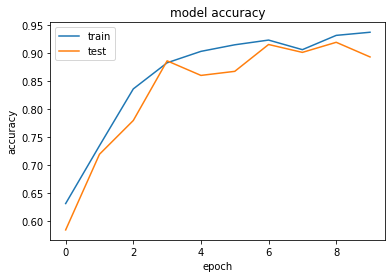

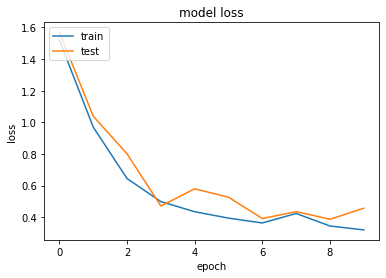

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#### depth = 2 #####



In [ ]:
data_augmentation = True


In [ ]:
n=2
depth = n * 6 + 2



In [ ]:
model = resnet_v1(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 99, 161, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 161, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 161, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 161, 16)  0           batch_normalization[0][0]        
________________________________________________________________________

In [ ]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d2_aug'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)


Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
Learning rate:  0.001
456/456 [==============================] - 328s 655ms/step - loss: 1.5615 - accuracy: 0.6245 - val_loss: 1.3211 - val_accuracy: 0.6505
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d2_aug/assets
Epoch 2/30
Learning rate:  0.001
456/456 [==============================] - 296s 647ms/step - loss: 0.8543 - accuracy: 0.7562 - val_loss: 1.6325 - val_accuracy: 0.6521
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d2_aug/assets
Epoch 3/30
Learning rate:  0.001
456/456 [==============================] - 296s 648ms/step - loss: 0.7036 - accuracy: 0.8057 - val_loss: 0.5553 - val_accuracy: 0.8550
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d2_aug/assets
Epoch 4/30
Learning rate:  0.001
456/456 [==============================] - 296s 649ms/step - loss: 0.5052 - accuracy: 0.8708 - val_loss: 0.6585 - val_accuracy: 0.8295
Epoch 5/30
Learning rate:  0.001
456/456

KeyboardInterrupt: ignored

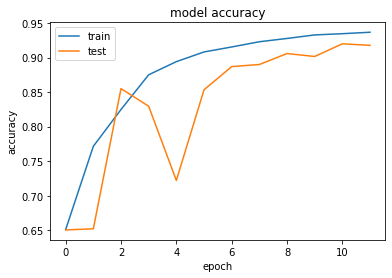

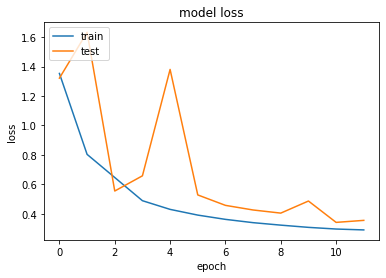

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Dfferent data augmentation ##

In [ ]:
data_augmentation=True


import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/models_resnet/model_resnet_noise_d3_aug2'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
# stosujemy tylko width shift 


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train_noise, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_noise, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=False,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train_noise)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train_noise, y_train, batch_size=128),
                        validation_data=(x_test_noise, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
Learning rate:  0.001
456/456 [==============================] - 475s 966ms/step - loss: 1.5560 - accuracy: 0.6348 - val_loss: 0.8898 - val_accuracy: 0.7462
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug2/assets
Epoch 2/30
Learning rate:  0.001
456/456 [==============================] - 438s 959ms/step - loss: 0.7268 - accuracy: 0.8167 - val_loss: 0.5917 - val_accuracy: 0.8608
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug2/assets
Epoch 3/30
Learning rate:  0.001
456/456 [==============================] - 438s 959ms/step - loss: 0.4364 - accuracy: 0.9081 - val_loss: 0.5445 - val_accuracy: 0.8720
INFO:tensorflow:Assets written to: drive/MyDrive/models_resnet/model_resnet_noise_d3_aug2/assets
Epoch 4/30
Learning rate:  0.001
456/456 [==============================] - 437s 957ms/step - loss: 0.3685 - accuracy: 0.9275 - val_loss: 0.5715 - val_accuracy: 0.8697
Epoch 5/30
Learning rate:  0.001
456/

KeyboardInterrupt: ignored